# BME Reweighting Tutorial

This notebook demonstrates **Bayesian Maximum Entropy (BME) reweighting** in STARLING.

## What is BME?

BME is a principled statistical method for refining molecular ensembles using experimental data. It:
- **Reweights** conformations to better match experimental observables
- **Minimizes bias** by preserving maximum entropy (staying close to the original ensemble)
- **Balances** fitting experimental data with maintaining ensemble diversity

The key parameter **θ (theta)** controls this tradeoff:
- **Low θ**: Fits data aggressively (may overfit, lose diversity)
- **High θ**: Preserves diversity (may underfit experimental data)
- **Optimal θ**: Found automatically via L-curve analysis


For more please see the following reference:


[1] Bottaro, S.; Bengtsen, T.; Lindorff-Larsen, K. Integrating Molecular Simulation and Experimental Data: A Bayesian/Maximum Entropy Reweighting Approach. Methods Mol. Biol. 2020, 2112, 219–240.

---

In [5]:
from starling import generate
import numpy as np
import matplotlib.pyplot as plt

from starling.structure.bme import ExperimentalObservable


## Step 1: Generate an Ensemble

We'll create a conformational ensemble for a disordered peptide sequence.

In [6]:
ens = generate("PKGSE"*10, conformations=400)

ens = ens["sequence_1"]

Using DDIM sampler


Progress through sequences:   0%|          | 0/1 [00:00<?, ?it/s]

DDIM steps (batch 1 of 4):   0%|          | 0/31 [00:00<?, ?it/s]

DDIM steps (batch 2 of 4):   0%|          | 0/31 [00:00<?, ?it/s]

DDIM steps (batch 3 of 4):   0%|          | 0/31 [00:00<?, ?it/s]

DDIM steps (batch 4 of 4):   0%|          | 0/31 [00:00<?, ?it/s]

## Step 2: Define Experimental Observable

We define an experimental measurement with:
- **value**: The experimental measurement (here, Rg = 25 Å)
- **uncertainty**: Experimental error (σ = 2 Å)
- **constraint**: How to apply it
  - `"equality"` (default): match value ± uncertainty
  - `"upper"`: don't exceed value
  - `"lower"`: don't go below value

For this example, we'll use a radius of gyration (Rg) measurement.

In [7]:

print("Initial mean Rg (uniform weights):",
      ens.radius_of_gyration(return_mean=True))

# ---------------------------------------------------------------------
# 1. Build the observable and calculated values
# ---------------------------------------------------------------------
# Target: Rg = 25 Å with some uncertainty (say 2 Å)
obs_rg = ExperimentalObservable(
    value=25.0,
    uncertainty=2.0,
    name="Rg"
)

# Per-frame calculated Rg values (shape: (n_frames,))
rg_values = ens.radius_of_gyration(return_mean=False)

# BME expects shape (n_frames, n_observables)
calculated_values = rg_values.reshape(-1, 1)

# ---------------------------------------------------------------------
# 2. Run BME reweighting with automatic theta selection
# ---------------------------------------------------------------------
result = ens.reweight_bme(
    observables=[obs_rg],
    calculated_values=calculated_values,
    theta=None,                 # auto-theta mode
    theta_range=(0.01, 30.0),   # scan range
    theta_n_points=60,          # number of theta points
    max_iterations=100000,
    optimizer="L-BFGS-B",
    initial_weights=None,       # uniform by default
    force_recompute=True,       # ignore any previous BME cache
    verbose=True,
    save_theta_scan_plot="theta_scan_rg.png",  # save to disk
    show=False,                                   # Set to true to show plot
    theta_method="perpendicular"  # use perpendicular distance method
)

# ---------------------------------------------------------------------
# 3. Inspect results & diagnostics
# ---------------------------------------------------------------------
print("\n--- Reweighting summary ---")
print(result)

print("\nOriginal mean Rg (uniform weights):",
      rg_values.mean())

print("Reweighted mean Rg (BME weights):",
      ens.radius_of_gyration(return_mean=True, use_bme_weights=True))

Initial mean Rg (uniform weights): 21.567878996292453

🔍 AUTOMATIC THETA SELECTION MODE
Performing L-curve analysis to find optimal theta...
  Range: 0.0100 to 30.0000
  Points: 60
  Selection method: perpendicular

[BME] Auto theta mode: running theta scan to select optimal θ...
  Progress: 1/60 (θ=0.0100)
  Progress: 5/60 (θ=0.0172)
  Progress: 10/60 (θ=0.0339)
  Progress: 15/60 (θ=0.0668)
  Progress: 20/60 (θ=0.1318)
  Progress: 25/60 (θ=0.2597)
  Progress: 30/60 (θ=0.5118)
  Progress: 35/60 (θ=1.0087)
  Progress: 40/60 (θ=1.9881)
  Progress: 45/60 (θ=3.9184)
  Progress: 50/60 (θ=7.7229)
  Progress: 55/60 (θ=15.2212)
  Progress: 60/60 (θ=30.0000)
[BME] Selected θ=3.421 via Perpendicular distance (Chi_squared_init=2.945, Chi_squared_final=0.629, N_eff=0.897).


THETA SCAN SUMMARY

Scan range: 0.0100 to 30.0000
Number of points: 60
Method: Perpendicular distance

RECOMMENDED THETA: 3.4212
Chi squared: 0.6291
N_eff:   0.8970
Relative Entropy:   0.1088
  • L-curve shows trade-off betwee

## Understanding the Output

### Automatic θ Selection
When `theta=None`, STARLING automatically:
1. **Scans** multiple θ values (here, 60 points from 0.01 to 30.0)
2. **Computes** χ² (fit quality) and Φ (diversity) for each
3. **Finds** the optimal θ using L-curve analysis
   - `theta_method="perpendicular"`: maximum perpendicular distance to line
   - `theta_method="curvature"`: maximum Menger curvature

### Key Metrics in Results
- **χ² (chi-squared)**: Goodness of fit (lower = better fit to data)
- **Φ (phi)**: Effective fraction of ensemble used (higher = more diversity)
  - Φ = 1.0: All frames equally weighted (no reweighting)
  - Φ < 0.5: Significant loss of diversity (may be problematic)
- **N_eff**: Effective number of frames = N × Φ
  - Shows how many frames meaningfully contribute

### The L-Curve
The theta scan plot shows the tradeoff:
- **Left panel**: χ² vs Φ (colored by log₁₀(θ))
  - Optimal θ is at the "knee" of this L-curve
- **Right panel**: Weight distribution at optimal θ
  - Shows how concentrated the weights are

---

## Step 3: Visualize Theta Scan

You can display the theta scan diagnostic plot at any time after reweighting.

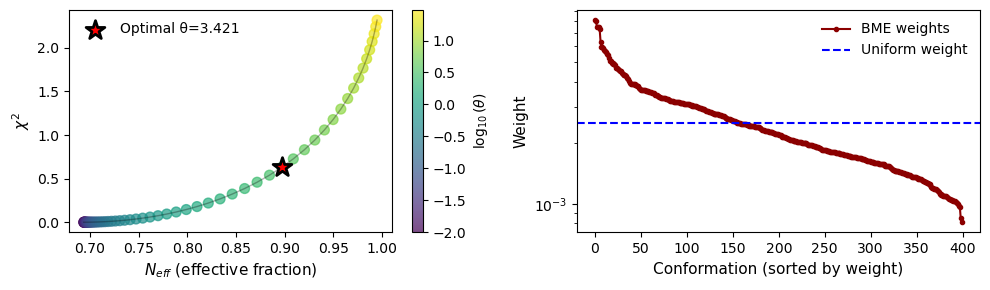

In [8]:
# Manually show plot if desired after reweighting
scan = ens.theta_scan_result
if scan is not None:
    fig = ens.view_theta_scan(show=True, figsize=(10, 3))

## Using BME Weights

Once reweighting is complete, BME weights are cached and can be used with any ensemble method:

```python
# Get reweighted mean values
rg_reweighted = ens.radius_of_gyration(return_mean=True, use_bme_weights=True)
ete_reweighted = ens.end_to_end_distance(return_mean=True, use_bme_weights=True)
rh_reweighted = ens.hydrodynamic_radius(return_mean=True, use_bme_weights=True)

# Get reweighted distance maps
mean_dmap = ens.distance_maps(return_mean=True, use_bme_weights=True)

# Get specific residue-residue distances
r_5_10 = ens.rij(5, 10, return_mean=True, use_bme_weights=True)
```

---

## Tips for BME Reweighting

### When to use manual θ
If you already know a good θ value (e.g., from previous analysis), use:
```python
result = ens.reweight_bme(..., theta=0.5, ...)  # 30x faster than auto-scan
```

### Multiple observables
BME can fit multiple observables simultaneously:
```python
obs_rg = ExperimentalObservable(25.0, 2.0, name="Rg")
obs_ete = ExperimentalObservable(70.0, 5.0, constraint="upper", name="End-to-end")

rg_vals = ens.radius_of_gyration(return_mean=False)
ete_vals = ens.end_to_end_distance(return_mean=False)
calculated = np.column_stack([rg_vals, ete_vals])

result = ens.reweight_bme([obs_rg, obs_ete], calculated)
```

### Diagnosing problems
Get detailed diagnostics with:
```python
result.print_diagnostics()
```

Common warnings:
- **Low Φ**: Increase θ or loosen uncertainties
- **High χ²**: Data incompatible with ensemble (may need better sampling)
- **Low N_eff**: Few frames dominate (ensemble may be too biased)

In [9]:
result.print_diagnostics()



BME DIAGNOSTIC REPORT

Optimization Status: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
Success: True
Iterations: 3

Chi-squared:
  Initial                                  2.9449
  Final                                    0.6291
  Improvement                              2.3158 (78.6%)

Ensemble Diversity:
  Phi (Φ, entropy fraction)                0.8970
  N_eff^(S) (entropy-based)                 358.8  / 400
  N_eff^(2) (1/Σw², Renyi-2)                320.5  / 400
  Theta (θ)                                3.4212

Weight Distribution:
  Min                                    8.11e-04
  Max                                    8.10e-03
  Std Dev                                1.24e-03
  Range (orders of magnitude)                 1.0

✓ Status: OK - No issues detected
